In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Statistics
using Plots
using DelimitedFiles
using DataFrames
using ProgressMeter
using StatsPlots

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1278


# Import data

In [2]:
#schneider data
all_schneider, train_data = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

# Helper functions needed for simulations

In [3]:
# gives 400/450/600 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end
# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end
# gives T4 dose at hour 24
function new_jonklaas_condition(u, t, integrator)
    return t - 24.0
end
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
function blakesley_t4_neg_logl(sol, time, data, Vp, σ) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_t3_neg_logl(sol, time, data, Vp, σ) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T3_predicted = sol(time[i])[2] * 651.0 / Vp
            tot_loss += (T3_predicted - data[i, 2])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_tsh_neg_logl(sol, time, data, Vtsh, σ, λ = 0.0) # sol includes T4/T3/TSH only
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
        # add penalty for 1st and 2nd high/low peak in TSH data (no penalty if λ=0)           
        for i in [9, 13, 24, 28]
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += λ * (predicted_tsh - data[i, 3])^2
        end
    end
    return tot_loss
end
# μmol (thyrosim unit for FT4) = Vb/100/777 ng/dL (jonklaas unit)
function FT4_to_TT4(FT4, Vb)
    # FT4 in ng/dL. Need to convert it to μmol
    f(TT4) = (0.000289 + 0.000214TT4 + 0.000128*TT4^2 + -8.83*10^-6*TT4^3) * TT4 - FT4 * Vb / 77700
    return fzero(f, 100)
end
# calculate new jonklaas error for T4 at end of sol
function jonklaas_T4_neg_logl(sol, data, Vp, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][1] * 777.0 / Vp
        tot_loss += (predicted - FT4_to_TT4(data))^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
# calculate new jonklaas error for T3 at end of sol
function jonklaas_T3_neg_logl(sol, data, Vp, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][4] * 651.0 / Vp
        tot_loss += (predicted - data)^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
# calculate new jonklaas error for TSH at end of sol
function jonklaas_TSH_neg_logl(sol, data, Vtsh, σ) # sol includes all comparments
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        predicted = sol[end][7] * 5.6 / Vtsh
        tot_loss += (predicted - data)^2 / 2σ^2 + log(2π) / 2 + log(σ)
    end
    return tot_loss
end
function schneider_end_tsh( 
    current_iter::Vector,
    fitting_index::Vector,
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    initial_tsh::Float64,
    initial_dose::Float64
    )

    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= @view(current_iter[1:length(fitting_index)])

    # run ODE simulation
    p[55] = initial_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk) # simulate for 6 weeks
    sol   = solve(prob, save_idxs=[1, 7])

    # return observed value
    return sol.u[end][2] * 5.6 / p[48]
end
function schneider_TSH_err(initTSH, sol, Vtsh)
    tsh = sol.u[end][2] * 5.6 / Vtsh
    return true
end
function TSH_within_interval(sol, Vtsh)
    tot_loss = 0
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if 0.5 ≤ tsh ≤ 4.5
        return true
    end
    return false
end
# Calculate mean/std of eythyroid dose (mcg/kg) for 
# male and female patients in different BMI categories 
function compute_patient_categories(
    sex::AbstractVector, 
    bmi::AbstractVector,
    euthyroid_dose::AbstractVector
    )
    categories = Dict{Symbol, Tuple{Float64, Float64}}()
    
    # get index for different cateories
    male_normal_idx = intersect(findall(iszero, sex), findall(x -> x < 24.9, bmi))
    male_overweight_idx = intersect(findall(iszero, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    male_obese_idx = intersect(findall(iszero, sex), findall(x -> 29.9 <= x, bmi))
    female_normal_idx = intersect(findall(isone, sex), findall(x -> x < 24.9, bmi))
    female_overweight_idx = intersect(findall(isone, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    female_obese_idx = intersect(findall(isone, sex), findall(x -> 29.9 <= x, bmi))
    
    # compute mean and var of euthyroid dose. If empty, set both as 0
    categories[:male_normal] = isempty(male_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_normal_idx]), std(euthyroid_dose[male_normal_idx]))
    categories[:male_overweight] = isempty(male_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_overweight_idx]), std(euthyroid_dose[male_overweight_idx]))
    categories[:male_obese] = isempty(male_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_obese_idx]), std(euthyroid_dose[male_obese_idx]))
    categories[:female_normal] = isempty(female_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_normal_idx]), std(euthyroid_dose[female_normal_idx]))
    categories[:female_overweight] = isempty(female_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_overweight_idx]), std(euthyroid_dose[female_overweight_idx]))
    categories[:female_obese] = isempty(female_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_obese_idx]), std(euthyroid_dose[female_obese_idx]))

    return categories
end
# male = 0, female = 1. Height in meters and weight in kg
function get_category(categories::Dict, sex, height, weight)
    bmi = weight / height^2
    if sex == 0
        if bmi < 24.9 
            return categories[:male_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:male_overweight]
        elseif 29.9 <= bmi
            return categories[:male_obese]
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            return categories[:female_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:female_overweight]
        elseif 29.9 <= bmi
            return categories[:female_obese]
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end
function update_logl_by_category!(logl_by_category::Vector, logl, sex, height, weight)
    bmi = weight / height^2
    if sex == 0 # male
        if bmi < 24.9 
            logl_by_category[8] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[16] += logl
        elseif 29.9 <= bmi
            logl_by_category[24] += logl
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            logl_by_category[32] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[40] += logl
        elseif 29.9 <= bmi
            logl_by_category[48] += logl
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end

update_logl_by_category! (generic function with 1 method)

# Result

In [4]:
# 4 penalized + exclude3jonklaas
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31;                  # A0, B0
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68]                      # reference BMI
# initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
#     37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
#     7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
# train_minimizer = [0.0028707939461898625, 0.015646808125177086, 113.76964453776945, 
#     60.83001009382769, 5.825567680898845, 4.743226098373893, 67.04088999652183, 8.4793759162597, 
#     7.910914075776539, 156.48916501278276, 15.81429201580925]

# 4 penalized + exclude3jonklaas + 33x blakesley
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31;                  # A0, B0
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68]                      # reference BMI
# initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
#     37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
#     7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
# train_minimizer = [0.002359872869249643, 0.011476560587951672, 270.6506451159571, 143.28403743785506, 
#     4.5701285132954235, 2.9608307901076176, 81.3735213606076, 6.7119462801549385, 6.210092228627189, 
#     85.95471113635797, 20.101303597629155]

# 4 penalized + exclude3jonklaas + 33x blakesley + 100x jonklaas T3
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31;                  # A0, B0
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68]                      # reference BMI
# initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
#     37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
#     7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
# train_minimizer = [0.0023945993262859343, 0.012555573500192435, 86.61094377109673, 45.7413662531384, 
#     3.100223484372122, 4.227912612360058, 8.190076965620644, 8.036178509526518, 6.14341819602538, 
#     19.99764911397885, 39.388523580282495]

# 4 penalized + exclude3jonklaas + 10x T3 blakesley
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31;                  # A0, B0
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68]                      # reference BMI
# initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
#     37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
#     7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
# train_minimizer = [0.0025686644200367662, 0.012262894305354618, 29.713200668643747, 15.965278035164014, 
#     0.009650270334367453, 4.39549003633322, 8.110269084605354, 7.034301471437983, 6.648933072712872, 
#     70.2940621067776, 24.716478260574423]

# 4 penalized + exclude3jonklaas + 5x T3 blakesley
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31;                  # A0, B0
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68]                      # reference BMI
# initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
#     37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
#     7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
# train_minimizer = [0.002574102662467239, 0.01253547884024734, 65.35966598545218, 34.82706717710392, 
#     1.0575233449437975, 3.30331020864706, 32.551565889546055, 5.6569838766015845, 6.5800591107594535,
#     132.14101385204202, 25.518057158150082]

# 4 penalized + exclude3jonklaas + 5x T3 blakesley + 10xJonklaasT3
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31;                  # A0, B0
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68]                      # reference BMI
# initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
#     37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
#     7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
# train_minimizer = [0.00265649697783089, 0.013929290847901434, 64.98925574361043, 35.10513093522959, 
#     1.8738866010072086, 4.388999308084615, 8.803366058192614, 7.106147303208966, 7.161039271953767, 
#     24.593853649380318, 35.81787327182913]

# 4 penalized + exclude3jonklaas + 5x T3 blakesley + 10xJonklaas TSH
# fitting_index =
#     [1; 13;                  # S4, VtshMax
#     30; 31;                  # A0, B0
#     49; 50; 51; 52; 53; 54;  # hill function parameters
#     68]                      # reference BMI
# initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
#     37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
#     7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
# train_minimizer = [0.003051129291970904, 0.012651213670628563, 62.17688825065105, 31.313339112369256, 
#     0.03898115532579317, 4.115770303496426, 33.28243234795109, 6.17283330356654, 7.707930213902346, 
#     65.7077168091801, 16.585712874930444]

# 4 penalized + exclude3jonklaas + 5x T3 blakesley + 5x Jonklaas T3
fitting_index =
    [1; 13;                  # S4, VtshMax
    30; 31;                  # A0, B0
    49; 50; 51; 52; 53; 54;  # hill function parameters
    68]                      # reference BMI
initial_guess = [0.00233909723258862, 0.01888250414072272, 70.34130520454524, 
    37.31550895469677, 4.534828778029588, 4.418055548810554, 9.289765460633825, 
    7.063722129732839, 6.800716242585794, 15.653958585100927, 22.5]
train_minimizer = [0.002611476846851042, 0.013364455510091808, 34.4443524570105, 18.946167905683332, 
    0.021803067962096013, 4.327624732448877, 10.477124204406655, 7.174906363977469, 6.805875120380582, 
    114.60242527633761, 34.63089697477158]

11-element Array{Float64,1}:
   0.002611476846851042
   0.013364455510091808
  34.4443524570105
  18.946167905683332
   0.021803067962096013
   4.327624732448877
  10.477124204406655
   7.174906363977469
   6.805875120380582
 114.60242527633761
  34.63089697477158

In [5]:
[fitting_index initial_guess train_minimizer]

11×3 Array{Float64,2}:
  1.0   0.0023391    0.00261148
 13.0   0.0188825    0.0133645
 30.0  70.3413      34.4444
 31.0  37.3155      18.9462
 49.0   4.53483      0.0218031
 50.0   4.41806      4.32762
 51.0   9.28977     10.4771
 52.0   7.06372      7.17491
 53.0   6.80072      6.80588
 54.0  15.654      114.602
 68.0  22.5         34.6309

## Blakesley (T4 and TSH data)

h = 1.77, w = 108.49513713226189


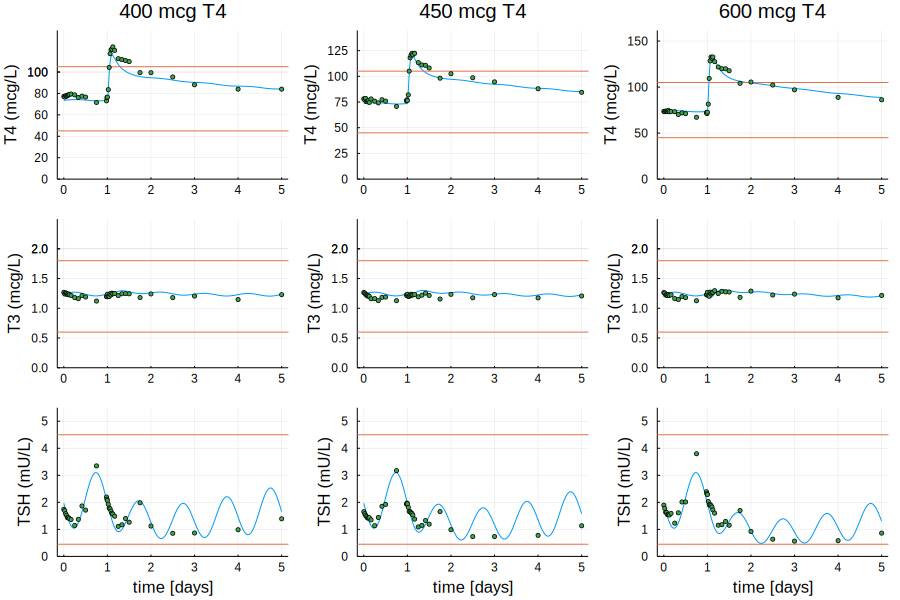

In [6]:
sex = true # 1 = male, 0 = female
bmi = train_minimizer[end]
h = sex ? 1.77 : 1.63
w = bmi * h^2
println("h = $h, w = $w")
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, h, w, sex, 
    fitting_index=fitting_index, p_being_optimized=train_minimizer) 
p[fitting_index] .= train_minimizer

#400 T4
# T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400", title="400 mcg T4")

# 450 T4
# T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
# find_patient_ic!(ic, p, 30)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450", title="450 mcg T4")

#600 T4
# T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
# find_patient_ic!(ic, p, 30)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600", title="600 mcg T4")

blakesley_plot = plot(a, b, c, layout=(1, 3), size=(900, 600))

In [12]:
savefig(blakesley_plot, "blakesley_plot.svg")

## Jonklaas data (T3 data)
overweight patients are those with BMI > 30.

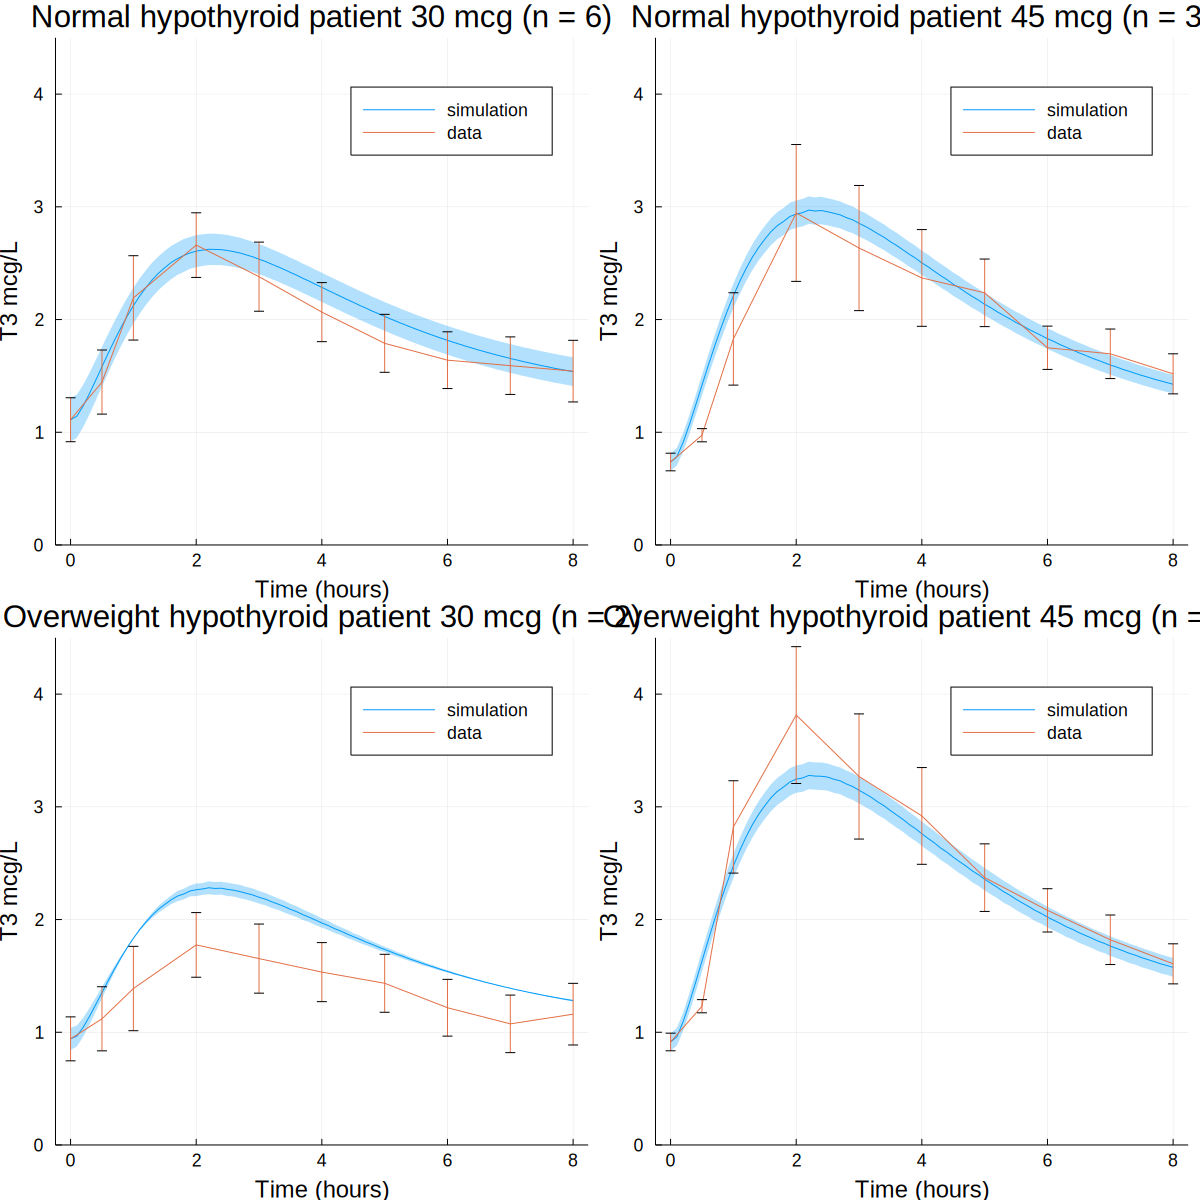

In [7]:
function jonklass_plot()
    jonklaas_times_simulation = collect(0.0:0.1:8.0)
    jonklaas_times_realdata = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0] # same time invervals as data
    points = length(jonklaas_times_simulation)
    normal_45_T4  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_T3  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_TSH = [Float64[] for i in 1:points]     # 3 patients
    normal_30_T4  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_T3  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_TSH = [Float64[] for i in 1:points]     # 6 patients
    overweight_45_T4  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_T3  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_TSH = [Float64[] for i in 1:points] # 4 patients
    overweight_30_T4  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_T3  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_TSH = [Float64[] for i in 1:points] # 2 patients

    for i in 1:15
        height, weight, sex = patient_param[i, :]
        T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
        T3dose = patient_dose[i]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex),
            fitting_index=fitting_index, p_being_optimized=train_minimizer) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        p[55] = 0.0
        p[56] = T3dose / 651.0
        cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
        p[fitting_index] = train_minimizer
        prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
        sol = solve(prob)

        BMI = weight / height^2
        if BMI < 30
            # normal patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        else
            # overweight patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        end
    end

    # compute averages
    normal_45_T4_mean = mean.(normal_45_T4)      # 3 patients
    normal_45_T3_mean = mean.(normal_45_T3)      # 3 patients
    normal_45_TSH_mean = mean.(normal_45_TSH)     # 3 patients
    normal_30_T4_mean = mean.(normal_30_T4)      # 6 patients
    normal_30_T3_mean = mean.(normal_30_T3)      # 6 patients
    normal_30_TSH_mean = mean.(normal_30_TSH)     # 6 patients
    overweight_45_T4_mean = mean.(overweight_45_T4)  # 4 patients
    overweight_45_T3_mean = mean.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_mean = mean.(overweight_45_TSH) # 4 patients
    overweight_30_T4_mean = mean.(overweight_30_T4)  # 2 patients
    overweight_30_T3_mean = mean.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_mean = mean.(overweight_30_TSH) # 2 patients

    # compute standard error of the mean
    normal_45_T4_std = std.(normal_45_T4) ./ sqrt(3)      # 3 patients
    normal_45_T3_std = std.(normal_45_T3) ./ sqrt(3)      # 3 patients
    normal_45_TSH_std = std.(normal_45_TSH) ./ sqrt(3)     # 3 patients
    normal_30_T4_std = std.(normal_30_T4) ./ sqrt(6)      # 6 patients
    normal_30_T3_std = std.(normal_30_T3) ./ sqrt(6)      # 6 patients
    normal_30_TSH_std = std.(normal_30_TSH) ./ sqrt(6)     # 6 patients
    overweight_45_T4_std = std.(overweight_45_T4) ./ sqrt(4)  # 4 patients
    overweight_45_T3_std = std.(overweight_45_T3) ./ sqrt(4)  # 4 patients
    overweight_45_TSH_std = std.(overweight_45_TSH) ./ sqrt(4) # 4 patients
    overweight_30_T4_std = std.(overweight_30_T4) ./ sqrt(2)  # 2 patients
    overweight_30_T3_std = std.(overweight_30_T3) ./ sqrt(2)  # 2 patients
    overweight_30_TSH_std = std.(overweight_30_TSH) ./ sqrt(2); # 2 patients

    # now add data
    normal_45_T4_data  = zeros(10, 3)     # 3 patients
    normal_45_T3_data  = zeros(10, 3)     # 3 patients
    normal_45_TSH_data = zeros(10, 3)     # 3 patients
    normal_30_T4_data  = zeros(10, 6)     # 6 patients
    normal_30_T3_data  = zeros(10, 6)     # 6 patients
    normal_30_TSH_data = zeros(10, 6)     # 6 patients
    overweight_45_T4_data  = zeros(10, 4) # 4 patients
    overweight_45_T3_data  = zeros(10, 4) # 4 patients
    overweight_45_TSH_data = zeros(10, 4) # 4 patients
    overweight_30_T4_data  = zeros(10, 2) # 2 patients
    overweight_30_T3_data  = zeros(10, 2) # 2 patients
    overweight_30_TSH_data = zeros(10, 2) # 2 patients

    normal_45_counter = 1
    normal_30_counter = 1
    overweight_45_counter = 1
    overweight_30_counter = 1
    for i in 1:15
        height, weight, sex = patient_param[i, :]
        BMI = weight / height^2
        T3dose = patient_dose[i]

        if BMI < 30
            # normal patient
            if T3dose == 30
                normal_30_T4_data[:, normal_30_counter] .= patient_t4[i, :]
                normal_30_T3_data[:, normal_30_counter] .= patient_t3[i, :]
                normal_30_TSH_data[:, normal_30_counter] .= patient_tsh[i, :]
                normal_30_counter += 1
            else
                normal_45_T4_data[:, normal_45_counter] .= patient_t4[i, :]
                normal_45_T3_data[:, normal_45_counter] .= patient_t3[i, :]
                normal_45_TSH_data[:, normal_45_counter] .= patient_tsh[i, :]
                normal_45_counter += 1
            end
        else
            # overweight patient
            if T3dose == 30
                overweight_30_T4_data[:, overweight_30_counter] .= patient_t4[i, :]
                overweight_30_T3_data[:, overweight_30_counter] .= patient_t3[i, :]
                overweight_30_TSH_data[:, overweight_30_counter] .= patient_tsh[i, :]
                overweight_30_counter += 1
            else
                overweight_45_T4_data[:, overweight_45_counter] .= patient_t4[i, :]
                overweight_45_T3_data[:, overweight_45_counter] .= patient_t3[i, :]
                overweight_45_TSH_data[:, overweight_45_counter] .= patient_tsh[i, :]
                overweight_45_counter += 1
            end
        end
    end

    # data's mean and std (of the mean)
    normal_45_T3_data_mean = mean(normal_45_T3_data, dims=2)
    normal_30_T3_data_mean = mean(normal_30_T3_data, dims=2)
    overweight_45_T3_data_mean = mean(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_mean = mean(overweight_30_T3_data, dims=2)
    normal_45_T3_data_std = std(normal_45_T3_data, dims=2) ./ sqrt(3)
    normal_30_T3_data_std = std(normal_30_T3_data, dims=2) ./ sqrt(6)
    overweight_45_T3_data_std = std(overweight_45_T3_data, dims=2) ./ sqrt(4)
    overweight_30_T3_data_std = std(overweight_30_T3_data, dims=2) ./ sqrt(2);

    Plots.scalefontsizes(1.5)

    # normal patients 45 mcg T4 plot
    normal_45_graph = plot(jonklaas_times_simulation, normal_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Normal hypothyroid patient 45 mcg (n = 3)")
    normal_45_graph = plot!(normal_45_graph, jonklaas_times_realdata, normal_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # normal patients 30 mcg T4 plot
    normal_30_graph = plot(jonklaas_times_simulation, normal_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_30_T3_std, fillalpha=.3, title="Normal hypothyroid patient 30 mcg (n = 6)")
    normal_30_graph = plot!(normal_30_graph, jonklaas_times_realdata, normal_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std)

    # overweight patients 45 mcg T4 plot
    overweight_45_graph = plot(jonklaas_times_simulation, overweight_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Overweight hypothyroid patient 45 mcg (n = 4)")
    overweight_45_graph = plot!(overweight_45_graph, jonklaas_times_realdata, overweight_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # overweight patients 30 mcg T4 plot
    overweight_30_graph = plot(jonklaas_times_simulation, overweight_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=overweight_30_T3_std, fillalpha=.3, title="Overweight hypothyroid patient 30 mcg (n = 2)")
    overweight_30_graph = plot!(overweight_30_graph, jonklaas_times_realdata, overweight_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std);
    
    combine = plot(normal_30_graph, normal_45_graph, 
        overweight_30_graph, overweight_45_graph, 
        layout=(2, 2), size=(1200, 1200))
    return combine
end
combine = jonklass_plot()

In [13]:
savefig(combine, "jonklaas_fig.svg")

# New Jonklaas plots

In [15]:
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
# simulate jonklaas patient over 16 weeks, interpolating weights weekly, returning T4/T3/TSH values
function simulate_one_jonklaas_patient_new(
    patient_idx::Int,
    result_minimzer::Vector, # first n elem is parameters, n+1:end is T4/T3 secrete rates
    fitting_index::Vector, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    jonklaas_secrete_rate_clusters::Vector;
    verbose::Bool = true
    )
    # return vectors
    T4 = Float64[]
    T3 = Float64[]
    TSH = Float64[]
    times = Float64[]
    
    # other parameters
    dial = [1.0; 0.88; 1.0; 0.88]
    nsamples = size(jonklaas_patient_param, 1)
    cbk = PeriodicCallback(add_dose!, 24) 
    weight_w1 = jonklaas_patient_param[:, 1] # week 1 weight
    height = jonklaas_patient_param[:, 3]
    sex = convert(BitVector, jonklaas_patient_param[:, 4])
    secretion_rates = @view(result_minimzer[length(fitting_index)+1:end])
    
    # run model to steady state before actual simulation
#     cluster = jonklaas_secrete_rate_clusters[patient_idx]
#     dial[1] = secretion_rates[2cluster - 1]
#     dial[3] = secretion_rates[2cluster]
    dial[1] = dial[3] = 1.0
    sol = simulate(height[patient_idx], weight_w1[patient_idx], sex[patient_idx], days=50, dial=dial, 
        warmup=false, fitting_index=fitting_index, parameters=result_minimzer[1:length(fitting_index)])
    _, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx], sex[patient_idx],
        fitting_index=fitting_index, p_being_optimized=train_minimizer)
    p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
    
    # run first 8 week simulations, interpolate weight weekly
    weight_diff = (jonklaas_patient_param[patient_idx, 2] - jonklaas_patient_param[patient_idx, 1]) / 16.0
    dial[1] = dial[3] = 0.0
    for week in 1:8
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, 
            sex[patient_idx], fitting_index=fitting_index, p_being_optimized=train_minimizer)
        p[55] = jonklaas_patient_dose[patient_idx, 1] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = week == 1 ? 777.0 * sol[1, :] / p[47] : vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = week == 1 ? 651.0 * sol[4, :] / p[47] : vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = week == 1 ? 5.6 * sol[7, :] / p[48] : vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = week == 1 ? sol.t : vcat(times, sol.t[2:end] .+ times[end])
    end

    # run next 8 week, interpolate weight weekly
    verbose && println("week 1-8  dose = ", jonklaas_patient_dose[patient_idx, 1])
    verbose && println("week 9-16 dose = ", jonklaas_patient_dose[patient_idx, 2])
    for week in 9:16
        # reset parameters using new weight
        ic, p = initialize(dial, true, height[patient_idx], weight_w1[patient_idx] + week*weight_diff, 
            sex[patient_idx], fitting_index=fitting_index, p_being_optimized=train_minimizer)
        p[55] = jonklaas_patient_dose[patient_idx, 2] / 777.0
        p[fitting_index] .= @view(result_minimzer[1:length(fitting_index)])
        # use last week's end value
        ic .= sol[end]
        ic[10] += p[55] # manually add dose for first day of the week
        prob = ODEProblem(thyrosim,ic,(0.0, 168.0),p,callback=cbk)
        sol  = solve(prob)
        # record each week's value for plotting later 
        T4 = vcat(T4, 777.0 * sol[1, 2:end] / p[47])
        T3 = vcat(T3, 651.0 * sol[4, 2:end] / p[47])
        TSH = vcat(TSH, 5.6 * sol[7, 2:end] / p[48])
        times = vcat(times, sol.t[2:end] .+ times[end])
    end
    
    return T4, T3, TSH, times
end

function plot_jonklaas_new(
    patient_idx::Int,
    jonklaas_patient_param::Matrix, 
    T4::Vector,    # simulated T4
    T3::Vector,    # simulated T3
    TSH::Vector,   # simulated TSH
    times::Vector, # time intervals (units = days)
    FT4data::Matrix,   # data
    T3data::Matrix,    # data
    TSHdata::Matrix;   # data
    title::AbstractString="Thyrosim simulation (Jonklaas new data)",
    automargins::Bool=true,
    )

    markersize = 2
    
    # get plasma volume for 3 time points to calculate TT4
    sex = Bool(jonklaas_patient_param[patient_idx, 4])
    height = jonklaas_patient_param[patient_idx, 3]
    weight_w1 = jonklaas_patient_param[patient_idx, 1]
    Vb = Thyrosim.blood_volume(height, weight_w1, sex) # use blood volume instead of Vp??
    Vp, _ = Thyrosim.plasma_volume(height, weight_w1, sex)
    
    # get predicted T4 (need to convert μmol to μg/L)
    t_data = [0.0, 56, 112] # 8 and 16 weeks
#     T4data = [FT4_to_TT4(FT4data[patient_idx, 2], Vb) * 777 / Vp, 
#               FT4_to_TT4(FT4data[patient_idx, 3], Vb) * 777 / Vp, 
#               FT4_to_TT4(FT4data[patient_idx, 4], Vb) * 777 / Vp]
    
    # parameters to adjust figure limits
    t4lim, t3lim, tshlim = 140, 4, 10
    if automargins
        t4lim = max(1.2maximum(T4), 110.0)# , 1.2T4data...)
        t3lim = max(1.2maximum(T3), 2.5, 1.2T3data[patient_idx, :]...)
        tshlim = max(1.2maximum(TSH), 5.5, 1.2TSHdata[patient_idx, :]...)
    end

    p1 = plot(times, T4, ylim=(0, t4lim), label="",ylabel="T4 (mcg/L)", title=title)
    hline!([45, 105], label= "")
#     scatter!(p1, t_data, T4data, label="", markersize=markersize)

    p2 = plot(times, T3, ylim=(0, t3lim), label="", ylabel="T3 (mcg/L)")
    hline!([0.6, 1.8], label= "")
    scatter!(p2, t_data, T3data[patient_idx, 2:4], label="", markersize=markersize)

    p3 = plot(times, TSH, ylim=(0, tshlim), label="", ylabel="TSH (mU/L)", xlabel="time [days]")
    hline!([0.45, 4.5], label= "")
    scatter!(p3, t_data, TSHdata[patient_idx, 2:4], label="", markersize=markersize)

    plot(p1, p2, p3, layout=(3, 1))
end

# μmol (thyrosim unit for FT4) = Vb/100/777 ng/dL (jonklaas unit)
function FT4_to_TT4(FT4, Vb)
    # FT4 in ng/dL. Need to convert it to μmol
    f(TT4) = (0.000289 + 0.000214TT4 + 0.000128*TT4^2 + -8.83*10^-6*TT4^3) * TT4 - FT4 * Vb / 77700
    TT4 = fzero(f, 100)
#     println("TT4 = $TT4")
#     println("FT4 * Vb / 77700 = ", FT4 * Vb / 77700)
#     println("(0.000289 + 0.000214TT4 + 0.000128*TT4^2 + -8.83*10^-6*TT4^3) * TT4 = ", (0.000289 + 0.000214TT4 + 0.000128*TT4^2 + -8.83*10^-6*TT4^3) * TT4 )
    return TT4
end

function summarize_fit(
    train_minimizer::AbstractVector{Float64},
    fitting_index::AbstractVector{Int};
    sex::Int = -1, # 1 = plot male only, 0 = only female, -1 = plot male and female
    BMI::AbstractRange = 1:100
    )
    patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()

    T4_data_p1, T4_sim_p1 = Float64[], Float64[]
    T4_data_p2, T4_sim_p2 = Float64[], Float64[]
    T4_data_p3, T4_sim_p3 = Float64[], Float64[]
    T3_data_p1, T3_sim_p1 = Float64[], Float64[]
    T3_data_p2, T3_sim_p2 = Float64[], Float64[]
    T3_data_p3, T3_sim_p3 = Float64[], Float64[]
    TSH_data_p1, TSH_sim_p1 = Float64[], Float64[]
    TSH_data_p2, TSH_sim_p2 = Float64[], Float64[]
    TSH_data_p3, TSH_sim_p3 = Float64[], Float64[]

    for i in 1:size(patient_param, 1)
        # decide if we want to run current patient
        s = jonklaas_patient_param[i, 4]
        sex == 1 && s == 0 && continue
        sex == 0 && s == 1 && continue
        w = jonklaas_patient_param[i, 1] # week 1 weight
        h = jonklaas_patient_param[i, 3] # height
        bmi = w / h^2
        first(BMI) ≤ bmi ≤ last(BMI) || continue
        
        # run simulation
        T4, T3, TSH, times = simulate_one_jonklaas_patient_new(i, train_minimizer, fitting_index, 
            jonklaas_patient_param, jonklaas_patient_dose, jonklaas_secrete_rate_clusters, verbose=false)
        p1_time = 1
        p2_time = findfirst(x -> x == 24*7*8, times)
        p3_time = length(times)

        # predicted T4/T3/TSH
        push!(T4_sim_p1, T4[p1_time])
        push!(T4_sim_p2, T4[p2_time])
        push!(T4_sim_p3, T4[p3_time])
        push!(T3_sim_p1, T3[p1_time])
        push!(T3_sim_p2, T3[p2_time])
        push!(T3_sim_p3, T3[p3_time])
        push!(TSH_sim_p1, TSH[p1_time])
        push!(TSH_sim_p2, TSH[p2_time])
        push!(TSH_sim_p3, TSH[p3_time])

        # actual T4/T3/TSH
#         T4data_p1, T4data_p2, T4data_p3 = FT4_to_TT4.(patient_t4[i, 2:4])
        T3data_p1, T3data_p2, T3data_p3 = patient_t3[i, 2:4]
        TSHdata_p1, TSHdata_p2, TSHdata_p3 = patient_tsh[i, 2:4]
#         push!(T4_data_p1, T4data_p1)
#         push!(T4_data_p2, T4data_p2)
#         push!(T4_data_p3, T4data_p3)
        push!(T3_data_p1, T3data_p1)
        push!(T3_data_p2, T3data_p2)
        push!(T3_data_p3, T3data_p3)
        push!(TSH_data_p1, TSHdata_p1)
        push!(TSH_data_p2, TSHdata_p2)
        push!(TSH_data_p3, TSHdata_p3)
    end

#     T4_t1_plt = boxplot(T4_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
#         legend=false, title="T4 (time 1)")
#     boxplot!(T4_t1_plt, T4_data_p1)

#     T4_t2_plt = boxplot(T4_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
#         legend=false, title="T4 (time 2)")
#     boxplot!(T4_t2_plt, T4_data_p2)

#     T4_t3_plt = boxplot(T4_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT4 (mcg/L)", 
#         legend=false, title="T4 (time 3)")
#     boxplot!(T4_t3_plt, T4_data_p3)

    T3_t1_plt = boxplot(T3_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 1)", ylim=(0.5, 2.0))
    boxplot!(T3_t1_plt, T3_data_p1)

    T3_t2_plt = boxplot(T3_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 2)", ylim=(0.5, 2.0))
    boxplot!(T3_t2_plt, T3_data_p2)

    T3_t3_plt = boxplot(T3_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TT3 (mcg/L)", 
        legend=false, title="T3 (time 3)", ylim=(0.5, 2.0))
    boxplot!(T3_t3_plt, T3_data_p3)

    TSH_t1_plt = boxplot(TSH_sim_p1, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 1)", ylim=(0.0, 5.0))
    boxplot!(TSH_t1_plt, TSH_data_p1)

    TSH_t2_plt = boxplot(TSH_sim_p2, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 2)", ylim=(0.0, 5.0))
    boxplot!(TSH_t2_plt, TSH_data_p2)

    TSH_t3_plt = boxplot(TSH_sim_p3, xticks=(1:1:2, ["Prediction", "data"]), ylabel="TSH (mU/L)", 
        legend=false, title="TSH (time 3)", ylim=(0.0, 5.0))
    boxplot!(TSH_t3_plt, TSH_data_p3)
    
#     combined = plot(T4_t1_plt, T4_t2_plt, T4_t3_plt,
#         T3_t1_plt, T3_t2_plt, T3_t3_plt,
#         TSH_t1_plt, TSH_t2_plt, TSH_t3_plt,
#         size=(800, 600), layout=(3, 3))
    combined = plot(T3_t1_plt, T3_t2_plt, T3_t3_plt,
        TSH_t1_plt, TSH_t2_plt, TSH_t3_plt,
        size=(800, 600), layout=(2, 3))
    return combined
end

jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data_new()
jonklaas_secrete_rate_clusters = [4,2,2,1,3,1,3,1,2,1,2,4,1,2,1,3,1,2,3,1,3,4,4,1,1,3,4,1,1,1,2,1,1];

## Prefit

Average simulated patients vs real data for Jonklaas patients. 

$$BlakesleyT4 + BlakesleyT3 + BlakesleyTSH + \sum_{i=1}^{50} (Jonklaas T3) + \sum_{i=1}^{50} (Jonklaas TSH)$$

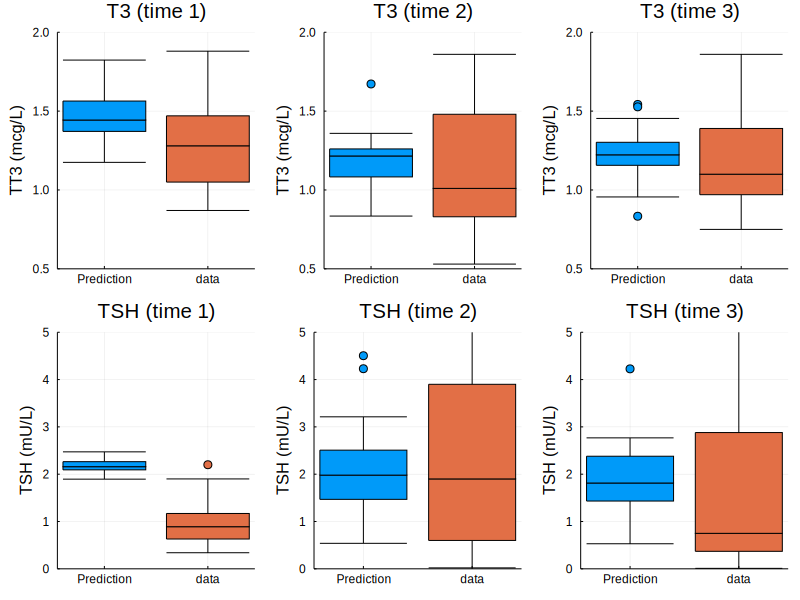

In [20]:
plt = summarize_fit(initial_guess, fitting_index) 
# savefig(plt, "jonklaas_new_prefit.svg")

## Postfit (5x Blakesley T3)

$$BlakesleyT4 + 5 * BlakesleyT3 + BlakesleyTSH + 1 * \sum_{i=1}^{50} (Jonklaas T3)_i + 1 * \sum_{i=1}^{50} (Jonklaas TSH)_i$$

Estimated BMI $\approx 25.5$

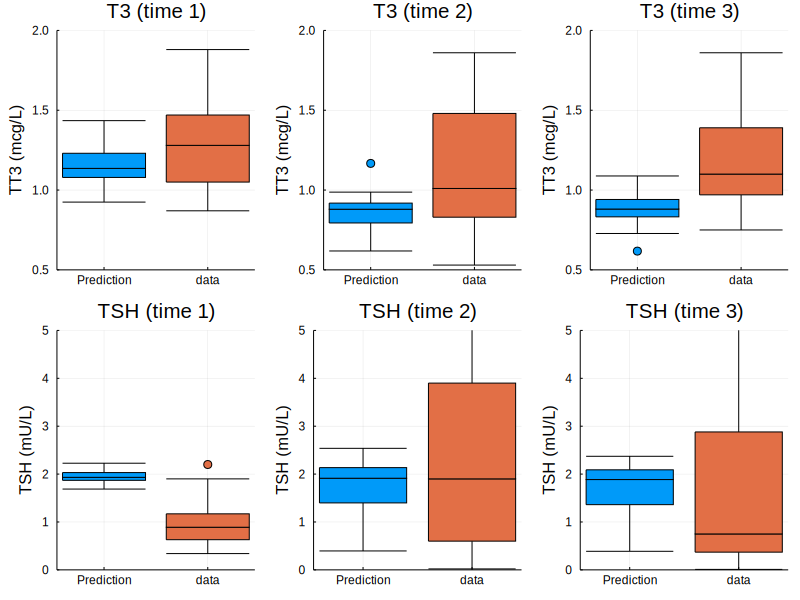

In [8]:
postfit = summarize_fit(train_minimizer, fitting_index)
# savefig(postfit, "jonklaas_new_postfit.svg")

## Postfit (5x Jonklaas T3)

$$BlakesleyT4 + BlakesleyT3 + BlakesleyTSH + 5 * \sum_{i=1}^{50} (Jonklaas T3)_i + 1 * \sum_{i=1}^{50} (Jonklaas TSH)_i$$

Estimated BMI $\approx 34.6$

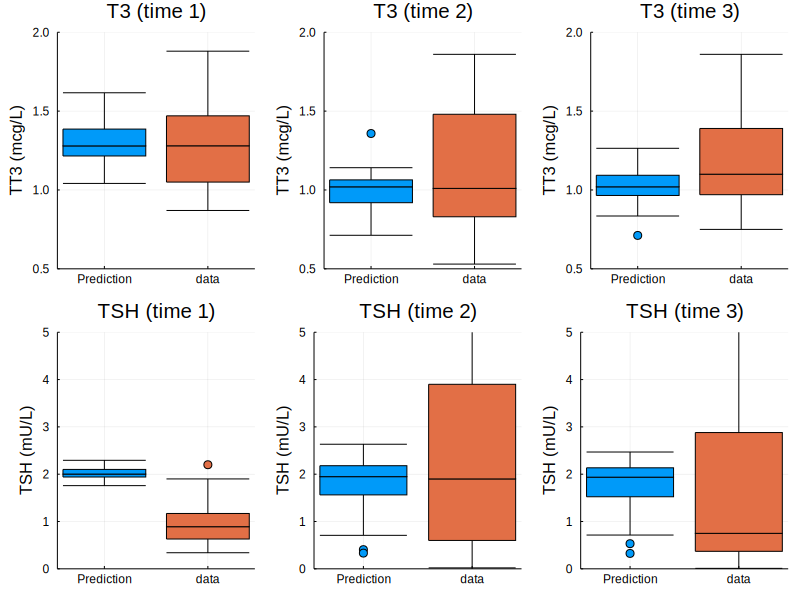

In [31]:
postfit = summarize_fit(train_minimizer, fitting_index)
# savefig(postfit, "jonklaas_new_postfit.svg")

## Postfit (10x Blakesley T3)

$$BlakesleyT4 + 10 * BlakesleyT3 + BlakesleyTSH + 1 * \sum_{i=1}^{50} (Jonklaas T3)_i + 1 * \sum_{i=1}^{50} (Jonklaas TSH)_i$$

Estimated BMI $\approx 24.7$

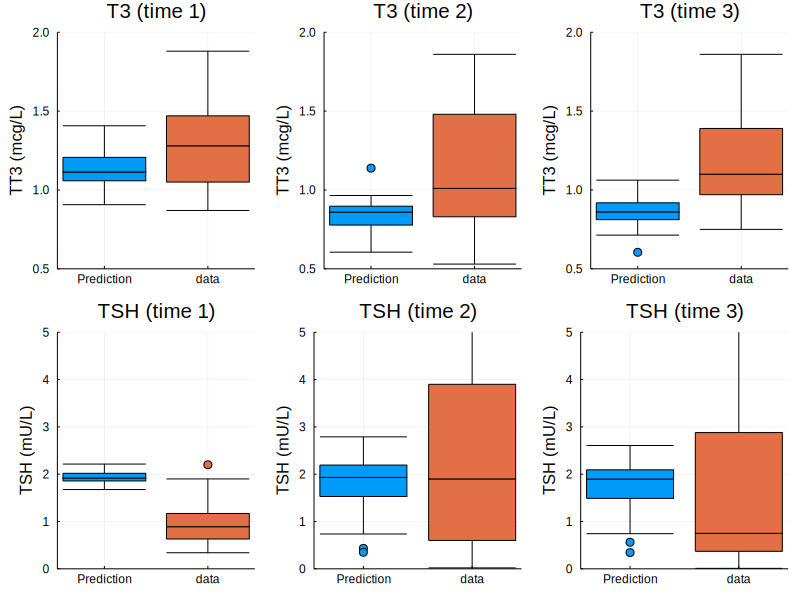

In [9]:
postfit = summarize_fit(train_minimizer, fitting_index)
# savefig(postfit, "jonklaas_new_postfit.svg")

## Postfit (5x Blakesley T3, 10x Jonklaas T3)

$$BlakesleyT4 + 5 * BlakesleyT3 + BlakesleyTSH + 10 * \sum_{i=1}^{50} (Jonklaas T3)_i + 1 * \sum_{i=1}^{50} (Jonklaas TSH)_i$$

Estimated BMI $\approx 35.8$

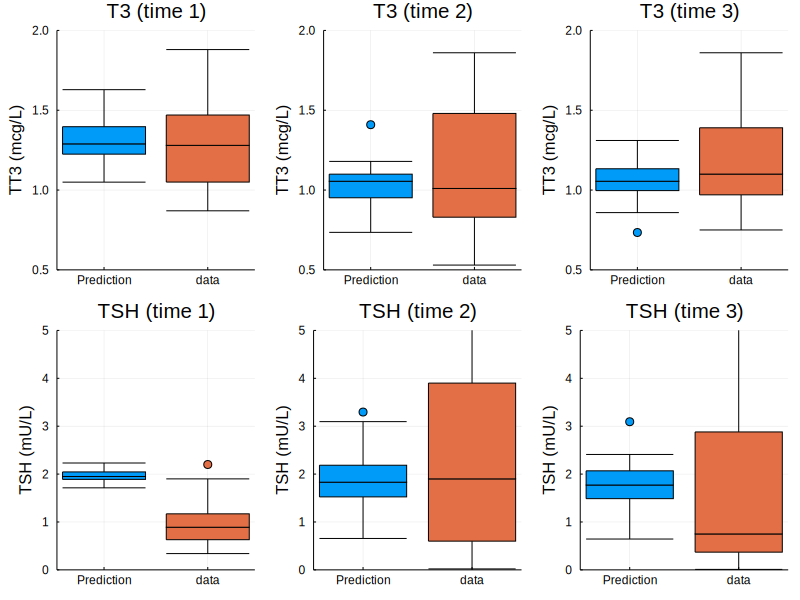

In [8]:
postfit = summarize_fit(train_minimizer, fitting_index)
# savefig(postfit, "jonklaas_new_postfit.svg")

## Postfit (5x Blakesley T3, 10x Jonklaas TSH)

$$BlakesleyT4 + 5 * BlakesleyT3 + BlakesleyTSH + 1 * \sum_{i=1}^{50} (Jonklaas T3)_i + 10 * \sum_{i=1}^{50} (Jonklaas TSH)_i$$

Estimated BMI $\approx 16.6$

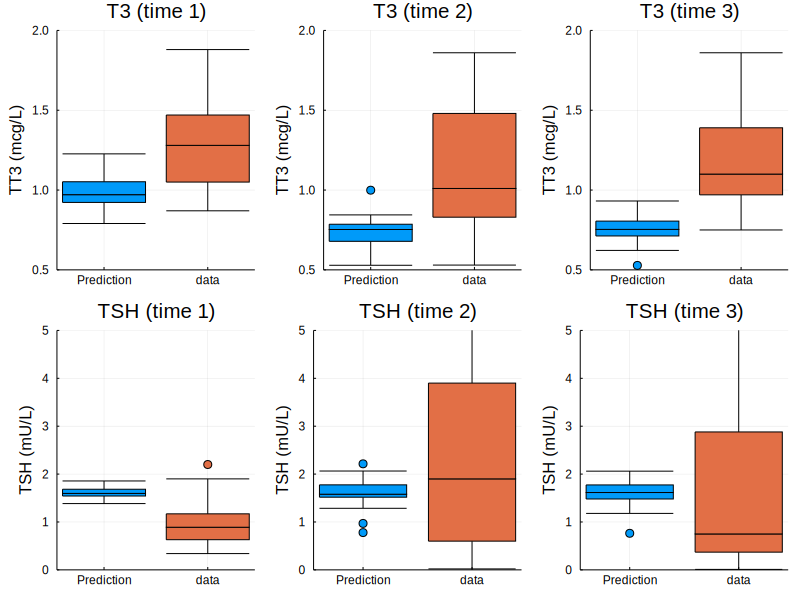

In [12]:
postfit = summarize_fit(train_minimizer, fitting_index)
# savefig(postfit, "jonklaas_new_postfit.svg")

## Postfit 33x blakesley

$$33 * BlakesleyT4 + 33 * BlakesleyT3 + 33 * BlakesleyTSH + 1 * \sum_{i=1}^{50} (Jonklaas T3)_i + \sum_{i=1}^{50} (Jonklaas TSH)_i$$
and note that
$$ 33 * BlakesleyT4 = \sum_{i=1}^{33} (BlakesleyT4)_i$$

Estimated BMI $\approx 20.1$

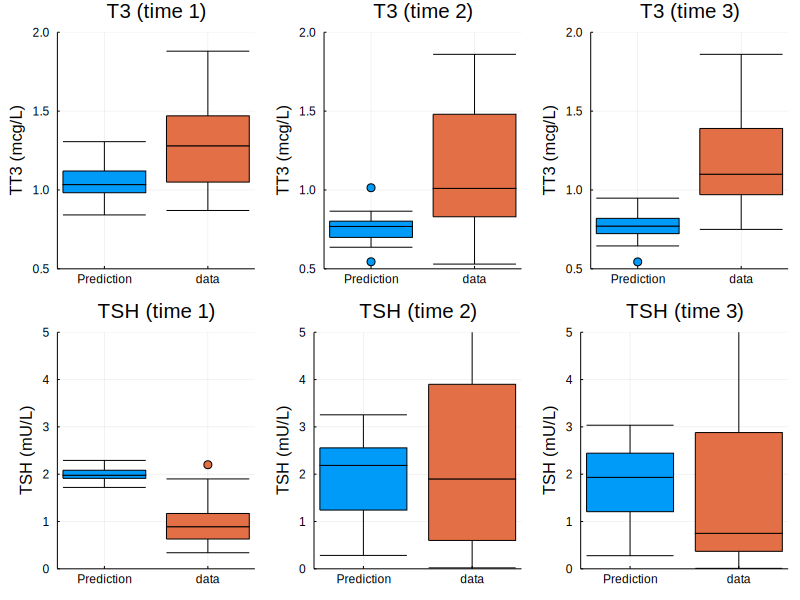

In [9]:
postfit = summarize_fit(train_minimizer, fitting_index)
# savefig(postfit, "jonklaas_new_postfit.svg")

## Postfit 33x blakesley + 100x Jonklaas T3

$$33 * BlakesleyT4 + 33 * BlakesleyT3 + 33 * BlakesleyTSH + 100 * \sum_{i=1}^{50} (Jonklaas T3) + \sum_{i=1}^{50} (Jonklaas TSH)$$

Estimated BMi $\approx 39$

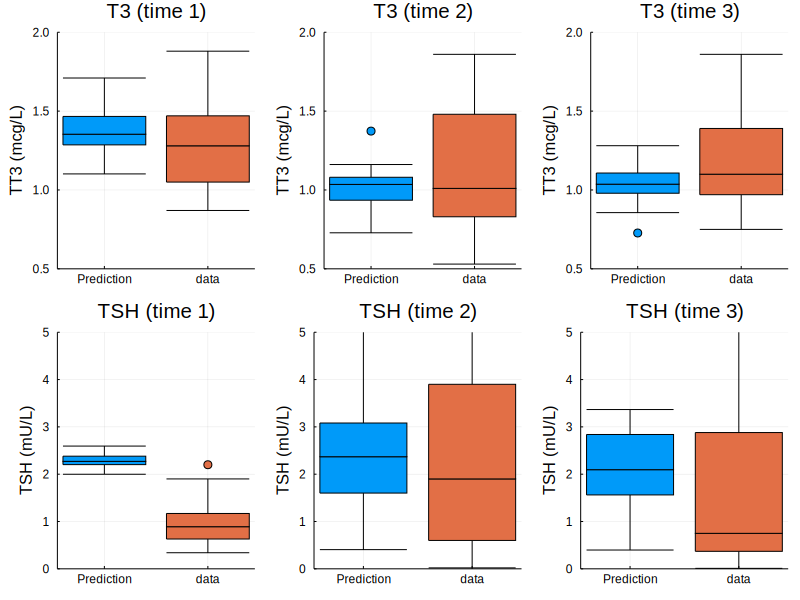

In [11]:
postfit = summarize_fit(train_minimizer, fitting_index)
# savefig(postfit, "jonklaas_new_postfit.svg")

## Postfit (full simulation)

week 1-8  dose = 125.0
week 9-16 dose = 137.0


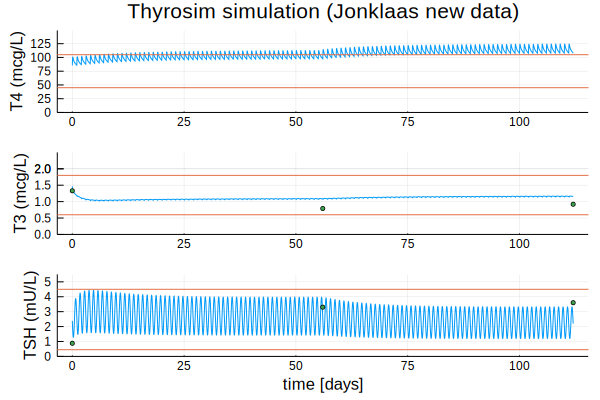

In [12]:
# make simulation
idx = 20
T4, T3, TSH, times = simulate_one_jonklaas_patient_new(idx, train_minimizer, fitting_index, 
    jonklaas_patient_param, jonklaas_patient_dose, jonklaas_secrete_rate_clusters)
plot_jonklaas_new(idx, jonklaas_patient_param, T4, T3, TSH, times ./ 24, patient_t4, patient_t3, patient_tsh)

# Schneider plots

For each patient, we test various T4 doses (in intervals of 12.5 mcg) to see if they normalize TSH values, then compare it to data.

## Possible doses

We will test T4 doses from 62.5, 75 ... all the way to 325 mcg. The smallest and largest doses that achieve euthyroidism (i.e. $0.5 <=$ TSH in last day $<= 4.5$) will be used as the **predicted dosage**. 

+ min/max weight = 38.1/206.4 KG 
+ using 1.6 of T4 per KG -> 61 ~ 330 mcg of T4
+ So test dosages = 50 ~ 337.5 with 12.5 as increments

In [8]:
# helper functions
function find_doses(
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    cbk, # call back function
    p,   # parameter vector
    ic;  # initial condition
    tsh_only::Bool = true,
    verbose::Bool=false
    )
    
    possible_doses = 50.0:12.5:325.0
    mindose = 0.0
    maxdose = 0.0
    
    # check doses from bottom up
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])
        if tsh_only
            loss  = TSH_within_interval(sol, p[48])
        else
            loss  = TSH_and_T4_within_interval(sol, p[48], p[47])
        end
        
        if verbose
            t4  = sol.u[end][1] * 777.0 / p[47]
            tsh = sol.u[end][2] * 5.6 / p[48]
            println("    t4 = $t4, tsh = $tsh when dose/kg = $(dose/weight)")
        end
        
        # save doses that work
        if loss == 1
            mindose = dose
            break
        end
    end
    if mindose == 0
        mindose = Inf
    end
    
    # check doses from top to bottom
    for dose in Iterators.reverse(possible_doses)
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])
        if tsh_only
            loss = TSH_within_interval(sol, p[48])
        else
            loss = TSH_and_T4_within_interval(sol, p[48], p[47])
        end
        
        # save doses that work
        if loss == 1
            maxdose = dose
            break
        end
    end
    if maxdose == 0 
        maxdose = Inf
    end
    
    return maxdose, mindose
end

function TSH_within_interval(sol, Vtsh)
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if 0.5 ≤ tsh ≤ 4.5
        return true
    end
    return false
end

function TSH_and_T4_within_interval(sol, Vtsh, Vp)
    tot_loss = 0
    t4  = sol.u[end][1] * 777.0 / Vp
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if (0.5 ≤ tsh ≤ 4.5) && (45 ≤ t4 ≤ 105)
        return true
    end
    return false
end
function find_all_doses(train_data, train_minimizer, fitting_index; 
    tsh_only::Bool=true, verbose=false)
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    tspan  = 24train_data[!, Symbol("Days.to.euthyroid")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    
    # define vector of possible doses
    min_predicted_doses = zeros(size(train_data, 1))
    max_predicted_doses = zeros(size(train_data, 1))
    
    # model setup
    dial  = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true
    
    # loop over each patient
    pmeter = Progress(size(train_data, 1))
    Threads.@threads for i in 1:size(train_data, 1)
        cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
        w     = weight[i]
        h     = height[i]
        s     = Bool(sex[i])
        ic, p = initialize(dial, scale_Vp, h, w, s, fitting_index=fitting_index, p_being_optimized=train_minimizer)
        p[fitting_index] = train_minimizer
        ic[7] = init_tsh[i]

        # find dose
        verbose && println("sample $i, sex = $s, bmi = $(w/h^2): ")
        (maxdose, mindose) = find_doses(h, w, s, cbk, p, ic, tsh_only=tsh_only,verbose=verbose)
        min_predicted_doses[i] = mindose
        max_predicted_doses[i] = maxdose
        next!(pmeter)
    end
    
    return max_predicted_doses, min_predicted_doses
end

find_all_doses (generic function with 1 method)

In [9]:
function find_all_doses_new(train_data, train_minimizer, fitting_index; 
    tsh_only::Bool=true, verbose=false)
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    euthy_dose = convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")])
    init_dose  = convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")])
    
    # define return vectors
    predicted_doses = zeros(size(train_data, 1))
    predicted_t4 = zeros(size(train_data, 1))
    predicted_tsh = zeros(size(train_data, 1))
    
    # model setup
    dial  = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true
    
    # loop over each patient
    pmeter = Progress(size(train_data, 1))
    Threads.@threads for i in 1:size(train_data, 1)        
        cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
        w     = weight[i]
        h     = height[i]
        s     = Bool(sex[i])
        ic, p = initialize(dial, scale_Vp, h, w, s, fitting_index=fitting_index, p_being_optimized=train_minimizer)
        p[fitting_index] = train_minimizer
        ismissing(init_tsh[i]) ? continue : (ic[7] = init_tsh[i])

        # find dose
        best_dose, best_t4, best_tsh = find_best_dose(h, w, s, cbk, p, ic, 
            tsh_only=tsh_only, verbose=verbose)
        predicted_doses[i] = best_dose
        predicted_t4[i] = best_t4
        predicted_tsh[i] = best_tsh
        next!(pmeter)
    end
    
    return predicted_doses, predicted_t4, predicted_tsh
end

function find_best_dose(
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    cbk, # call back function
    p,   # parameter vector
    ic;  # initial condition
    tsh_only::Bool = false,
    verbose::Bool = false
    )
    
    possible_doses = 50.0:12.5:325.0
    best_dose = 0.0
    best_err = Inf
    best_t4 = 0.0
    best_tsh = 0.0
    
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, 1008),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])

        # calculate error
        t4  = sol.u[end][1] * 777.0 / p[47]
        tsh = sol.u[end][2] * 5.6 / p[48]
        if tsh_only
            err = abs(tsh - 2.5) # although 1.3 is average of schneider preop TSH value
        else
            err = abs(t4 - 75) / 60 + abs(tsh - 2.5) / 4
        end
        if err < best_err
            best_dose = dose
            best_err = err
            best_t4 = t4
            best_tsh = tsh
        end
    end
    
    verbose && println("sex = $sex, bmi = $(weight/height^2), best_dose = $(best_dose/weight), best_t4 = $best_t4, best_tsh = $best_tsh")

    return best_dose, best_t4, best_tsh
end

find_best_dose (generic function with 1 method)

In [10]:
Threads.nthreads()

1

## Check predicted dose based on TSH or TSH+T4

We find a dose that minimizes the following:

$$\frac{|T4 - 75|}{60} + \frac{|TSH - 2.5|}{4}$$

Note 75 and 2.5 are midpoints of T4 and TSH, and 60 and 4 are the length of the normal range of T4 and TSH. Thus, error are normalized between compartments.

In [13]:
@time predicted_doses, predicted_t4, predicted_tsh = find_all_doses_new(all_schneider, 
    train_minimizer, fitting_index, tsh_only=false, verbose=false);
[predicted_doses predicted_t4 predicted_tsh]

Progress: 100%|█████████████████████████████████████████| Time: 0:01:51

111.644498 seconds (940.53 M allocations: 62.831 GiB, 11.08% gc time)


598×3 Array{Float64,2}:
 175.0   75.2691  0.746263
 112.5   78.6844  2.84415
 112.5   99.4553  3.25902
 112.5  110.845   3.4552
 112.5   59.1472  2.36749
 112.5   94.0254  3.15824
 112.5   76.6865  2.7997
 112.5   63.7825  2.48961
 112.5   86.0205  3.00011
 112.5   83.2668  2.94287
 112.5   80.3045  2.87956
 112.5   84.9523  2.97808
 112.5   62.8869  2.46649
   ⋮              
 125.0   74.5605  2.10146
 162.5   73.6824  0.954185
 112.5   62.2975  2.45116
 112.5   85.2972  2.98522
 112.5   82.8688  2.93447
 175.0   74.0286  0.737557
 112.5   78.4949  2.83998
 112.5   77.4999  2.8179
 112.5   71.4638  2.67916
 112.5   78.8372  2.84752
 112.5   72.9343  2.71375
 112.5   81.4413  2.90407

In [14]:
writedlm("schneider_dosage_prediction_result14.txt", predicted_doses)

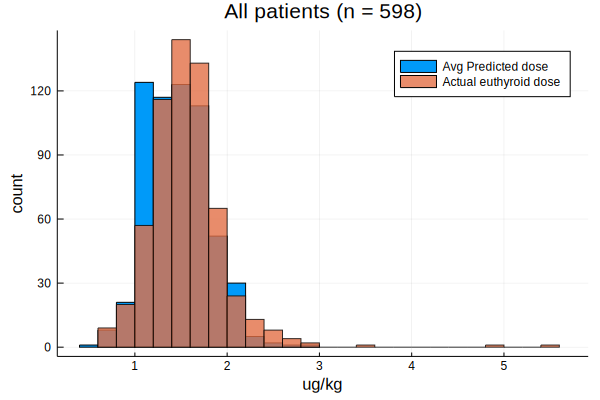

In [6]:
# import predicted dosages: max-dose/avg-dose/min-dose
# dosage_predicted = readdlm("schneider_dosage_prediction_result3.txt")[:, 2] # 38 h fit
# dosage_predicted = readdlm("schneider_dosage_prediction_result.txt")[:, 2] # 38 h + blakesley tsh fit
# dosage_predicted = readdlm("schneider_dosage_prediction_result4.txt") # 20 h fit using better dosage prediction alg

# latest fit 20 h fit (yes k02, no female ref vp)
# dosage_predicted = readdlm("schneider_dosage_prediction_result2.txt")[:, 2] # tsh + t4
# dosage_predicted = readdlm("schneider_dosage_prediction_result5.txt")[:, 2] # tsh only 
# dosage_predicted = readdlm("schneider_dosage_prediction_result6.txt") # tsh only, new objective

# latest fit 10 h fit (no k02, yes female ref vp)
# dosage_predicted = readdlm("schneider_dosage_prediction_result7.txt")[:, 2] # tsh only 
# dosage_predicted = readdlm("schneider_dosage_prediction_result8.txt")[:, 2] # tsh + t4 
# dosage_predicted = readdlm("schneider_dosage_prediction_result9.txt") # tsh + t4, new objective

# blakesley female + male fit (no fat compartment transport)
# dosage_predicted = readdlm("schneider_dosage_prediction_result10.txt") # tsh, new objective
# dosage_predicted = readdlm("schneider_dosage_prediction_result11.txt")[:, 2] # tsh + t4

# fitting on updated schneider data
# dosage_predicted = readdlm("schneider_dosage_prediction_result12.txt") # tsh only, 2.5 as TSH midpoint
# dosage_predicted = readdlm("schneider_dosage_prediction_result13.txt") # tsh + t4, 2.5 as TSH midpoint

# fitting on updated jonklaas data (+ 100 secretion rate parameters)
dosage_predicted = readdlm("schneider_dosage_prediction_result14.txt") # tsh + t4, 2.5 as TSH midpoint

# predicted dose
predicted_t4 = dosage_predicted ./ all_schneider[!, Symbol("Wt.kg")]
avgplt_all = histogram(predicted_t4, title="All patients (n = $(length(predicted_t4)))",
    bin=20, xlabel="ug/kg", ylabel="count", label="Avg Predicted dose")

# actual dose
actual_t4 = all_schneider[!, Symbol("LT4.euthyroid.dose")] ./ all_schneider[!, Symbol("Wt.kg")]
histogram!(avgplt_all, actual_t4, label="Actual euthyroid dose", bin=30, alpha=0.8)

In [7]:
male_idx = findall(iszero, all_schneider[!, :Sex])
female_idx = findall(isone, all_schneider[!, :Sex]);

average male euthyroid dose = 1.6535210273062932
    normal male euthyroid dose = 1.8141132354661407 predicted = 1.6953356935152966
    overweight male euthyroid dose = 1.6713232231709882 predicted = 1.4971165981315286
    obese male euthyroid dose = 1.5402443052044865 predicted = 1.3323048080963118


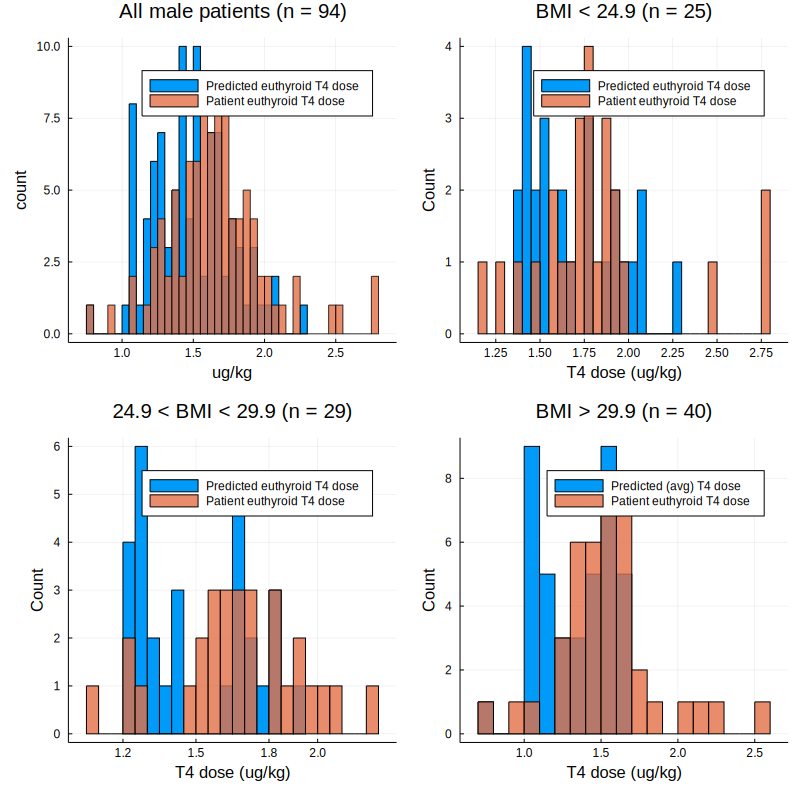

In [20]:
# import predicted dosages: max-dose/avg-dose/min-dose
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);
normal_male_idx = findall(iszero, all_schneider[normal_idx, :Sex])
overwt_male_idx = findall(iszero, all_schneider[overwt_idx, :Sex])
obese_male_idx  = findall(iszero, all_schneider[obese_idx , :Sex])

# all male patients
predicted_t4 = dosage_predicted[male_idx] ./ all_schneider[male_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[male_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[male_idx, Symbol("Wt.kg")]
println("average male euthyroid dose = ", mean(actual_t4))
avgplt_male = histogram(predicted_t4, 
    title="All male patients (n = $(length(predicted_t4)))", bin=50, 
    xlabel="ug/kg", ylabel="count", label="Predicted euthyroid T4 dose", alpha=1.0)
histogram!(avgplt_male, actual_t4, label="Patient euthyroid T4 dose", bin=50, alpha=0.8)

# normal male patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_weight = normal_weight[normal_male_idx]
normal_predicted_dose = dosage_predicted[normal_idx][normal_male_idx] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")][normal_male_idx] ./ normal_weight
println("    normal male euthyroid dose = ", mean(normal_euthy_dose), " predicted = ", mean(normal_predicted_dose))
normal_plt = histogram(normal_predicted_dose, label="Predicted euthyroid T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", 
    title="BMI < 24.9 (n = $(length(normal_predicted_dose)))", bin=20, fillalpha=1.0)
histogram!(normal_plt, normal_euthy_dose, label="Patient euthyroid T4 dose", bin=30, fillalpha=0.8)

# overweight male patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_weight = overweight_weight[overwt_male_idx]
overweight_predicted_dose = dosage_predicted[overwt_idx][overwt_male_idx] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")][overwt_male_idx] ./ overweight_weight
println("    overweight male euthyroid dose = ", mean(overweight_euthy_dose), " predicted = ", mean(overweight_predicted_dose))
overweight_plt = histogram(overweight_predicted_dose, label="Predicted euthyroid T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", 
    title="24.9 < BMI < 29.9 (n = $(length(overweight_predicted_dose)))", bin=20, 
    fillalpha=1.0)
histogram!(overweight_plt, overweight_euthy_dose, label="Patient euthyroid T4 dose", bin=30, fillalpha=0.8)

# obese patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_weight = obese_weight[obese_male_idx]
obese_predicted_dose = dosage_predicted[obese_idx][obese_male_idx] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")][obese_male_idx] ./ obese_weight
println("    obese male euthyroid dose = ", mean(obese_euthy_dose), " predicted = ", mean(obese_predicted_dose))
obese_plt = histogram(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", 
    title="BMI > 29.9 (n = $(length(obese_predicted_dose)))", bin=10, 
    fillalpha=1.0)
histogram!(obese_plt, obese_euthy_dose, label="Patient euthyroid T4 dose", bin=30, fillalpha=0.8)

male_combined = plot(avgplt_male, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [106]:
savefig(male_combined, "male_predicted_dose_per_kg.svg")

average female euthyroid dose = 1.5477957097700943
    normal female euthyroid dose = 1.791978853257014 predicted = 1.861770392093136
    overweight female euthyroid dose = 1.5385978946261236 predicted = 1.5433921920801488
    obese female euthyroid dose = 1.4068987463361027 predicted = 1.1813359179800862


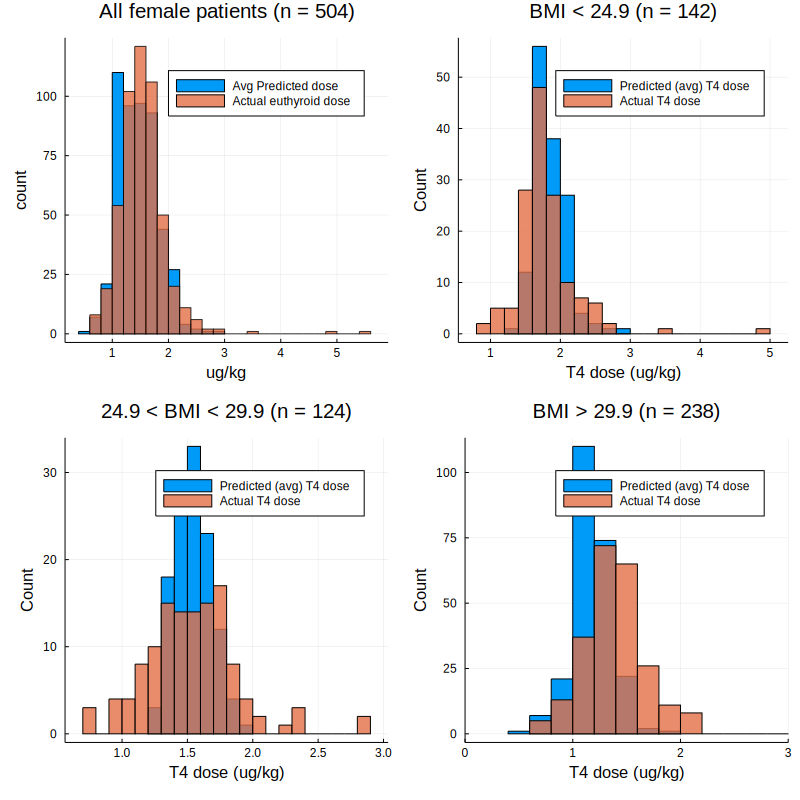

In [23]:
# import predicted dosages: max-dose/avg-dose/min-dose
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);
normal_female_idx = findall(isone, all_schneider[normal_idx, :Sex])
overwt_female_idx = findall(isone, all_schneider[overwt_idx, :Sex])
obese_female_idx  = findall(isone, all_schneider[obese_idx , :Sex])

# all female patients
predicted_t4 = dosage_predicted[female_idx] ./ all_schneider[female_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[female_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[female_idx, Symbol("Wt.kg")]
println("average female euthyroid dose = ", mean(actual_t4))
avgplt_female = histogram(predicted_t4, 
    title="All female patients (n = $(length(predicted_t4)))", bin=20, 
    xlabel="ug/kg", ylabel="count", label="Avg Predicted dose", alpha=1.0)
histogram!(avgplt_female, actual_t4, label="Actual euthyroid dose", bin=30, alpha=0.8)

# normal female patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_weight = normal_weight[normal_female_idx]
normal_predicted_dose = dosage_predicted[normal_idx][normal_female_idx] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")][normal_female_idx] ./ normal_weight
println("    normal female euthyroid dose = ", mean(normal_euthy_dose), " predicted = ", mean(normal_predicted_dose))
normal_plt = histogram(normal_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", 
    title="BMI < 24.9 (n = $(length(normal_predicted_dose)))", bin=10, fillalpha=1.0)
histogram!(normal_plt, normal_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.8)

# overweight female patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_weight = overweight_weight[overwt_female_idx]
overweight_predicted_dose = dosage_predicted[overwt_idx][overwt_female_idx] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")][overwt_female_idx] ./ overweight_weight
println("    overweight female euthyroid dose = ", mean(overweight_euthy_dose), " predicted = ", mean(overweight_predicted_dose))
overweight_plt = histogram(overweight_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", 
    title="24.9 < BMI < 29.9 (n = $(length(overweight_predicted_dose)))", bin=10, fillalpha=1.0)
histogram!(overweight_plt, overweight_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.8)

# obese female patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_weight = obese_weight[obese_female_idx]
obese_predicted_dose = dosage_predicted[obese_idx][obese_female_idx] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")][obese_female_idx] ./ obese_weight
println("    obese female euthyroid dose = ", mean(obese_euthy_dose), " predicted = ", mean(obese_predicted_dose))
obese_plt = histogram(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", xlim=(0, 3.0),
    title="BMI > 29.9 (n = $(length(obese_predicted_dose)))", bin=10, fillalpha=1.0)
histogram!(obese_plt, obese_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.8)

female_combined = plot(avgplt_female, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [118]:
savefig(female_combined, "female_predicted_dose_per_kg.svg")

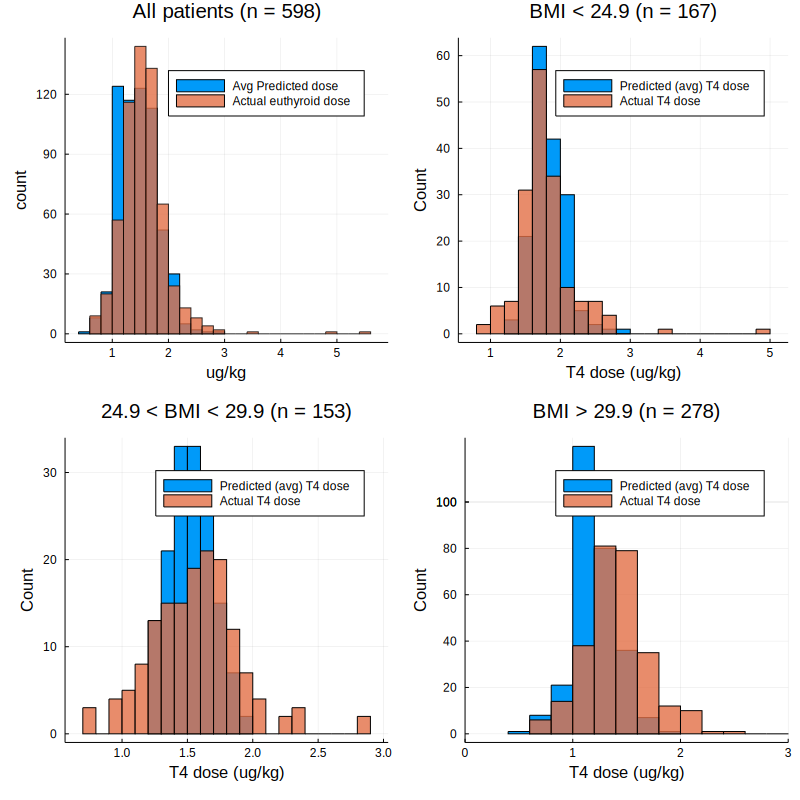

In [25]:
# all patients
# import predicted dosages: max-dose/avg-dose/min-dose
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);

# normal patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_predicted_dose = dosage_predicted[normal_idx] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")] ./ normal_weight
normal_plt = histogram(normal_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count",
    title="BMI < 24.9 (n = $(length(normal_predicted_dose)))", bin=10, fillalpha=1.0)
histogram!(normal_plt, normal_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.8)

# overweight patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_predicted_dose = dosage_predicted[overwt_idx] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")] ./ overweight_weight
overweight_plt = histogram(overweight_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count",
    title="24.9 < BMI < 29.9 (n = $(length(overweight_predicted_dose)))", bin=10, 
    fillalpha=1.0)
histogram!(overweight_plt, overweight_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.8)


# obese patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_predicted_dose = dosage_predicted[obese_idx] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")] ./ obese_weight
obese_plt = histogram(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xlabel="T4 dose (ug/kg)", ylabel="Count", xlim=(0, 3.0),
    title="BMI > 29.9 (n = $(length(obese_predicted_dose)))", bin=10, fillalpha=1.0)
histogram!(obese_plt, obese_euthy_dose, label="Actual T4 dose", bin=30, fillalpha=0.8)

combined = plot(avgplt_all, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [116]:
savefig(combined, "predicted_dose_per_kg.svg")

# Box plots

average female euthyroid dose = 1.5477957097700943
    normal female euthyroid dose = 1.791978853257014 predicted = 1.861770392093136
    overweight female euthyroid dose = 1.5385978946261236 predicted = 1.5433921920801488
    obese female euthyroid dose = 1.4068987463361027 predicted = 1.1813359179800862


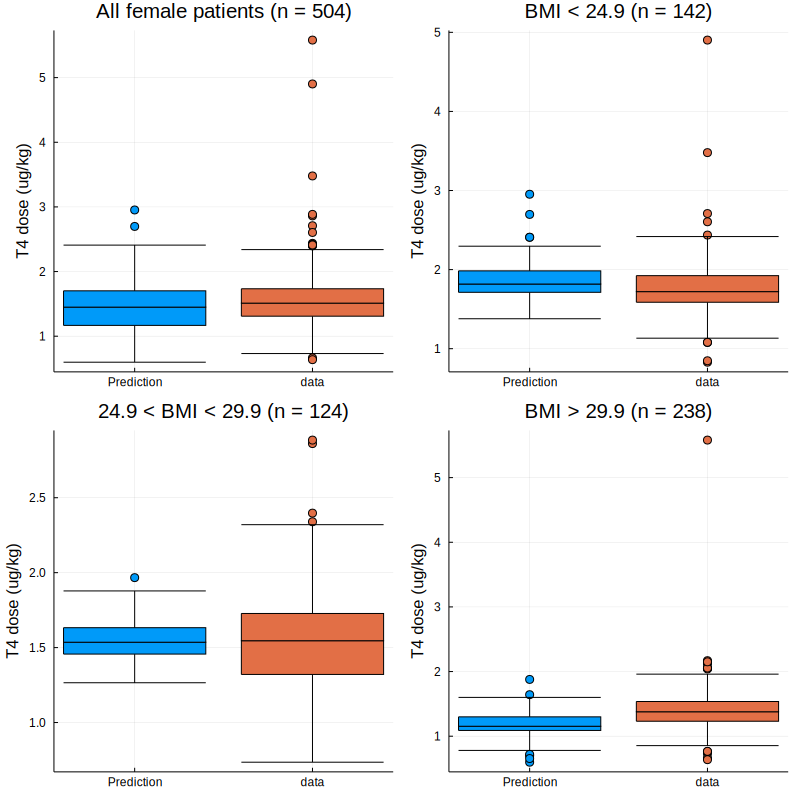

In [13]:
using StatsPlots

# import predicted dosages: max-dose/avg-dose/min-dose
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);
normal_female_idx = findall(isone, all_schneider[normal_idx, :Sex])
overwt_female_idx = findall(isone, all_schneider[overwt_idx, :Sex])
obese_female_idx  = findall(isone, all_schneider[obese_idx , :Sex])

# all female patients
predicted_t4 = dosage_predicted[female_idx] ./ all_schneider[female_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[female_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[female_idx, Symbol("Wt.kg")]
println("average female euthyroid dose = ", mean(actual_t4))
avgplt_female = boxplot(predicted_t4,
    title="All female patients (n = $(length(predicted_t4)))",
    ylabel="T4 dose (ug/kg)", label="Avg Predicted dose",
    xticks=(1:1:2, ["Prediction", "data"]), legend=false)
boxplot!(avgplt_female, actual_t4, label="Actual euthyroid dose")

# normal female patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_weight = normal_weight[normal_female_idx]
normal_predicted_dose = dosage_predicted[normal_idx][normal_female_idx] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")][normal_female_idx] ./ normal_weight
println("    normal female euthyroid dose = ", mean(normal_euthy_dose), " predicted = ", mean(normal_predicted_dose))
normal_plt = boxplot(normal_predicted_dose, label="Predicted (avg) T4 dose", legend=false,
    ylabel="T4 dose (ug/kg)", title="BMI < 24.9 (n = $(length(normal_predicted_dose)))",
    xticks=(1:1:2, ["Prediction", "data"]))
boxplot!(normal_plt, normal_euthy_dose)

# overweight female patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_weight = overweight_weight[overwt_female_idx]
overweight_predicted_dose = dosage_predicted[overwt_idx][overwt_female_idx] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")][overwt_female_idx] ./ overweight_weight
println("    overweight female euthyroid dose = ", mean(overweight_euthy_dose), " predicted = ", mean(overweight_predicted_dose))
overweight_plt = boxplot(overweight_predicted_dose, label="Predicted (avg) T4 dose", 
    xticks=(1:1:2, ["Prediction", "data"]), ylabel="T4 dose (ug/kg)", 
    title="24.9 < BMI < 29.9 (n = $(length(overweight_predicted_dose)))", legend=false)
boxplot!(overweight_plt, overweight_euthy_dose, label="Actual T4 dose")

# obese female patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_weight = obese_weight[obese_female_idx]
obese_predicted_dose = dosage_predicted[obese_idx][obese_female_idx] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")][obese_female_idx] ./ obese_weight
println("    obese female euthyroid dose = ", mean(obese_euthy_dose), " predicted = ", mean(obese_predicted_dose))
obese_plt = boxplot(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xticks=(1:1:2, ["Prediction", "data"]), ylabel="T4 dose (ug/kg)", 
    title="BMI > 29.9 (n = $(length(obese_predicted_dose)))", legend=false)
boxplot!(obese_plt, obese_euthy_dose, label="Actual T4 dose")

female_combined = plot(avgplt_female, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [120]:
savefig(female_combined, "boxplot_female_predicted_dose.svg")

average male euthyroid dose = 1.6535210273062932
    normal male euthyroid dose = 1.8141132354661407 predicted = 1.6953356935152966
    overweight male euthyroid dose = 1.6713232231709882 predicted = 1.4971165981315286
    obese male euthyroid dose = 1.5402443052044865 predicted = 1.3323048080963118


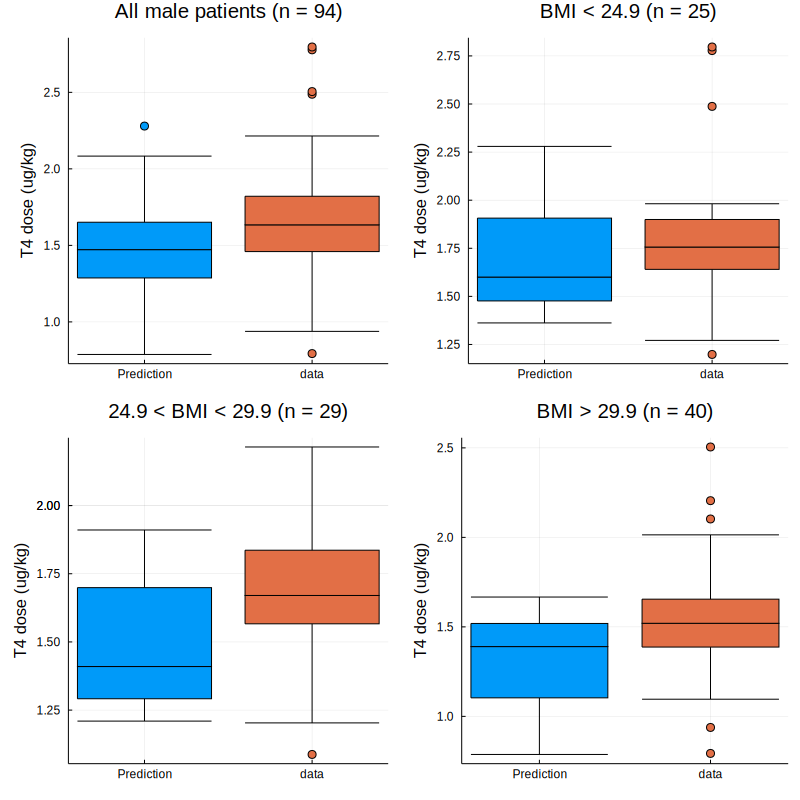

In [14]:
# import predicted dosages: max-dose/avg-dose/min-dose
normal_idx = findall(bmi -> bmi < 24.9, all_schneider[!, :BMI])
overwt_idx = findall(bmi -> 24.9 <= bmi < 29.9, all_schneider[!, :BMI])
obese_idx  = findall(bmi -> 29.9 <= bmi, all_schneider[!, :BMI]);
normal_male_idx = findall(iszero, all_schneider[normal_idx, :Sex])
overwt_male_idx = findall(iszero, all_schneider[overwt_idx, :Sex])
obese_male_idx  = findall(iszero, all_schneider[obese_idx , :Sex])

# all male patients
predicted_t4 = dosage_predicted[male_idx] ./ all_schneider[male_idx, Symbol("Wt.kg")]
actual_t4 = all_schneider[male_idx, Symbol("LT4.euthyroid.dose")] ./ all_schneider[male_idx, Symbol("Wt.kg")]
println("average male euthyroid dose = ", mean(actual_t4))
avgplt_male = boxplot(predicted_t4,
    title="All male patients (n = $(length(predicted_t4)))",
    ylabel="T4 dose (ug/kg)", label="Avg Predicted dose",
    xticks=(1:1:2, ["Prediction", "data"]), legend=false)
boxplot!(avgplt_male, actual_t4, label="Actual euthyroid dose")

# normal male patients (avg dose)
normal_weight = all_schneider[normal_idx, Symbol("Wt.kg")]
normal_weight = normal_weight[normal_male_idx]
normal_predicted_dose = dosage_predicted[normal_idx][normal_male_idx] ./ normal_weight
normal_euthy_dose = all_schneider[normal_idx, Symbol("LT4.euthyroid.dose")][normal_male_idx] ./ normal_weight
println("    normal male euthyroid dose = ", mean(normal_euthy_dose), " predicted = ", mean(normal_predicted_dose))
normal_plt = boxplot(normal_predicted_dose, label="Predicted (avg) T4 dose", legend=false,
    ylabel="T4 dose (ug/kg)", title="BMI < 24.9 (n = $(length(normal_predicted_dose)))", xticks=(1:1:2, ["Prediction", "data"]))
boxplot!(normal_plt, normal_euthy_dose)

# overweight male patients (avg dose)
overweight_weight = all_schneider[overwt_idx, Symbol("Wt.kg")]
overweight_weight = overweight_weight[overwt_male_idx]
overweight_predicted_dose = dosage_predicted[overwt_idx][overwt_male_idx] ./ overweight_weight
overweight_euthy_dose = all_schneider[overwt_idx, Symbol("LT4.euthyroid.dose")][overwt_male_idx] ./ overweight_weight
println("    overweight male euthyroid dose = ", mean(overweight_euthy_dose), " predicted = ", mean(overweight_predicted_dose))
overweight_plt = boxplot(overweight_predicted_dose, label="Predicted (avg) T4 dose", 
    xticks=(1:1:2, ["Prediction", "data"]), ylabel="T4 dose (ug/kg)", 
    title="24.9 < BMI < 29.9 (n = $(length(overweight_predicted_dose)))", legend=false)
boxplot!(overweight_plt, overweight_euthy_dose, label="Actual T4 dose")

# obese male patients (avg dose)
obese_weight = all_schneider[obese_idx, Symbol("Wt.kg")]
obese_weight = obese_weight[obese_male_idx]
obese_predicted_dose = dosage_predicted[obese_idx][obese_male_idx] ./ obese_weight
obese_euthy_dose = all_schneider[obese_idx, Symbol("LT4.euthyroid.dose")][obese_male_idx] ./ obese_weight
println("    obese male euthyroid dose = ", mean(obese_euthy_dose), " predicted = ", mean(obese_predicted_dose))
obese_plt = boxplot(obese_predicted_dose, label="Predicted (avg) T4 dose", 
    xticks=(1:1:2, ["Prediction", "data"]), ylabel="T4 dose (ug/kg)", 
    title="BMI > 29.9 (n = $(length(obese_predicted_dose)))", legend=false)
boxplot!(obese_plt, obese_euthy_dose, label="Actual T4 dose")

male_combined = plot(avgplt_male, normal_plt, overweight_plt, obese_plt, layout = (2, 2), size=(800, 800))

In [122]:
savefig(male_combined, "boxplot_male_predicted_dose.svg")

## Look closely at normal weight female patients

In [43]:
all_schneider[normal_female_idx, 21]

136-element Array{Float64,1}:
 125.0
  82.0
  75.0
 125.0
 112.0
 100.0
 100.0
  75.0
 112.0
 100.0
 112.0
 100.0
 125.0
   ⋮  
 112.0
 100.0
  50.0
 125.0
  88.0
 112.0
  88.0
 112.0
  88.0
 100.0
 125.0
 125.0

In [49]:
normal_female_dosages = result[normal_idx[normal_female_idx], :]
normal_female_euthyroid_dose = all_schneider[normal_female_idx, 21]

[normal_female_dosages normal_female_euthyroid_dose]

136×4 Array{Float64,2}:
 187.5  162.5  137.5  175.0
 187.5  162.5  137.5  150.0
 187.5  162.5  137.5  125.0
 187.5  162.5  137.5   82.0
 187.5  162.5  137.5  125.0
 187.5  162.5  137.5  112.0
 187.5  162.5  137.5   88.0
 187.5  162.5  137.5  150.0
 187.5  162.5  137.5  175.0
 187.5  162.5  137.5  112.0
 187.5  162.5  137.5   75.0
 187.5  162.5  137.5  200.0
 187.5  162.5  137.5  150.0
   ⋮                       
 187.5  162.5  137.5  150.0
 187.5  162.5  137.5  112.0
 187.5  162.5  137.5  150.0
 187.5  162.5  137.5  137.0
 187.5  162.5  137.5   75.0
 187.5  162.5  137.5  100.0
 187.5  162.5  137.5  175.0
 187.5  162.5  137.5  125.0
 187.5  162.5  137.5  150.0
 187.5  162.5  137.5  112.0
 187.5  162.5  137.5   88.0
 187.5  162.5  137.5  100.0

Conclusion: seems like the low dosage is not low enough.

# Record predicted dose and error into schneider dataframe

In [39]:
function one_simulation(
    current_iter,
    fitting_index, 
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    initial_tsh::Float64,
    euthyroid_dose::Float64,
    initial_dose::Float64
    )
    
    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex, fitting_index=fitting_index, p_being_optimized=train_minimizer)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= current_iter
    
    # calculate error for euthyroid dose
    p[55] = euthyroid_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
    sol   = solve(prob, save_idxs=7)
    
    #increment error
    tot_loss += compute_euthyroid_dose_l2_error(sol, p[48])
    
    # when initial dose != euthyroid dose, calculate error
    if initial_dose != euthyroid_dose
        p[55] = initial_dose / 777.0
        prob = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol = solve(prob, save_idxs=7)
        tot_loss += compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose, p[48])
    end

    return tot_loss
end

function record_error(
    train_data, 
    train_minimizer, 
    fitting_index, 
    euthy_dose,
    init_dose, 
    )
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    tspan  = 24train_data[!, Symbol("Days.to.euthyroid")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    
    # model setup
    cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
    dial  = [0.0; 0.88; 0.0; 0.88]
    scale_Vp = true

    # loop over each patient
    patient_error = zeros(size(train_data, 1))
    for i in 1:size(train_data, 1)
        w     = weight[i]
        h     = height[i]
        s     = Bool(sex[i])
        t     = Float64(tspan[i])
        ic, p = initialize(dial, scale_Vp, h, w, s, fitting_index=fitting_index, p_being_optimized=train_minimizer)
        p[fitting_index] = train_minimizer
        ic[7] = init_tsh[i]
        
        # record error
        patient_error[i] = one_simulation(train_minimizer, fitting_index, h, w, s, t, 
            init_tsh[i], euthy_dose[i], init_dose[i])
    end
    
    return patient_error
end

record_error (generic function with 1 method)

In [55]:
# read predicted dosage
result = readdlm("schneider_dosage_prediction_result.txt")

# calculate each patient's (unscaled) error contribution to schneider 
# patient_error = record_error(all_schneider, train_minimizer, fitting_index, 
#     all_schneider[!, Symbol("LT4.euthyroid.dose")], 
#     all_schneider[!, Symbol("LT4.initial.dose")])

# combine results
combined = deepcopy(all_schneider)
insertcols!(combined, size(combined, 2) + 1, (:max_predicted_dose => result[:, 1]))
insertcols!(combined, size(combined, 2) + 1, (:avg_predicted_dose => result[:, 2]))
insertcols!(combined, size(combined, 2) + 1, (:min_predicted_dose => result[:, 3]))
# insertcols!(combined, size(combined, 2) + 1, (:error_contribution => patient_error))

,Surgeon,Race,Sex,Age,Wt.lb,Wt.kg,Ht.in,Ht.m,BMI,LT4.initial.dose
,String,Int64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64
1,3,1,0,60.1,254,115.2,71.5,1.8161,34.9279,175.0
2,1,1,1,65.0,170,77.1,68.0,1.7272,25.8446,125.0
3,2,1,1,61.4,113,51.3,62.0,1.5748,20.6855,100.0
4,1,1,1,66.4,103,46.7,61.0,1.5494,19.4531,88.0
5,2,1,0,64.4,224,101.6,68.0,1.7272,34.0572,175.0
6,1,1,1,63.2,227,103.0,62.0,1.5748,41.5323,150.0
7,1,1,1,59.0,167,75.7,64.0,1.6256,28.6463,112.0
8,1,1,1,50.3,203,92.1,65.0,1.651,33.7882,137.0
9,2,1,0,69.1,204,92.5,71.0,1.8034,28.4418,175.0


In [56]:
using CSV
CSV.write("schneider_dose_error.csv", combined)

"schneider_dose_error.csv"